# Day 1 - ML Workflow

The objective of this exercise is to use the tools and methods you learnt during the previous weeks, in order to solve a **real challenge**.

The problem to solve is a **Kaggle Competition**: [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction). The goal is to predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.

Building a machine learning model requires a few different steps 

## Steps
1. [Get the data](#part1)
2. [Explore the data](#part2)
3. [Data cleaning](#part3)
4. [Evaluation metric](#part4)
5. [Model baseline](#part5)
6. [Build your first model](#part6)
7. [Model evaluation](#part7)
8. [Kaggle submission](#part8)
9. [Model iteration](#part9)

## 1. Get the data <a id='part1'></a>

The dataset is available on [Kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data)

First of all:
- Follow the instructions to download the training and test sets
- Put the datasets in a separate folder on your local disk, that you can name "data" for example.

Now we are going to use Pandas to read and explore the datasets.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
pip install s3fs

You should consider upgrading via the '/Users/edgarminault/.pyenv/versions/3.7.7/envs/lewagon/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The training dataset is relatively big (~5GB). 
So let's only open a portion of it.  
👉 Go to [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/) to see how to open a portion of csv file and store it into a dataframe. (ex: just read 1 million rows maximum)  
💡 NB: here we will read portion of a file **directly from an url**, texactly the same can be done with local file

In [3]:
%%time
url = 's3://wagon-public-datasets/taxi-fare-train.csv'
df = pd.read_csv(url, nrows=100000)

CPU times: user 779 ms, sys: 185 ms, total: 964 ms
Wall time: 6.25 s


Now let's display the first rows to understand the different fields 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
key                  100000 non-null object
fare_amount          100000 non-null float64
pickup_datetime      100000 non-null object
pickup_longitude     100000 non-null float64
pickup_latitude      100000 non-null float64
dropoff_longitude    100000 non-null float64
dropoff_latitude     100000 non-null float64
passenger_count      100000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


## 2. Explore the data <a id='part2'></a>

Before trying to solve the prediction problem, we need to get a better understanding of the data. 
For that, libraries like Pandas and Seaborn are your best friends. 
Firt of all, make you sure you have [Seaborn](https://seaborn.pydata.org/) installed and import it into your notebook. Note that this can be also useful to import `matplotlib.pyplot` to customize a few things.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)

<Figure size 864x360 with 0 Axes>

### There are multiple things we want to do in terms of data exploration.

- You first want to look at the distribution of the variable you are going to predict: "fare_amount"
- Then you want to vizualize other variable distributions
- And finally it is often very helpful to compute and vizualise correlation between the target the variable and other variables.
- Also, look for any missing values, or other irregularities.

### Explore the target variable
- Compute simple statistics of the target variable (min, max, mean, std, ...)
- Plot distributions

In [6]:
df.fare_amount.describe()

count    100000.000000
mean         11.354652
std           9.716777
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         200.000000
Name: fare_amount, dtype: float64

/Users/edgarminault/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


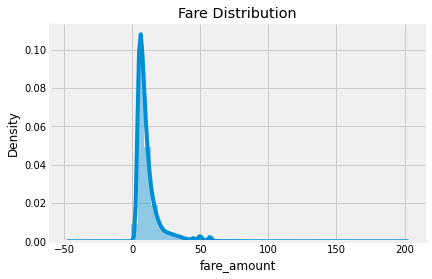

In [7]:
%matplotlib inline
def plot_dist(series=df["fare_amount"], title="Fare Distribution"):
    sns.distplot(series)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

/Users/edgarminault/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


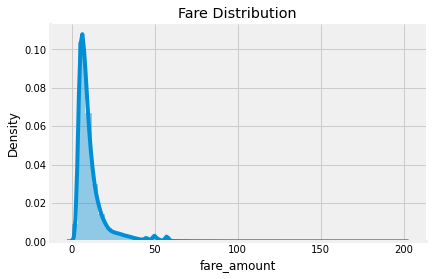

In [8]:
# drop absurd values 
df = df[df.fare_amount.between(0, 6000)]
plot_dist(df.fare_amount)

In [9]:
# We can also visualise binned fare_amount variable
df['fare-bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 50, 5)), include_lowest=True).astype('str')
# Uppermost bin
df.loc[df['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'
# apply this to clean up the first bin's label
df['fare-bin'] = df['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))
# sort by fare the correct look in the chart
df = df.sort_values(by='fare_amount')

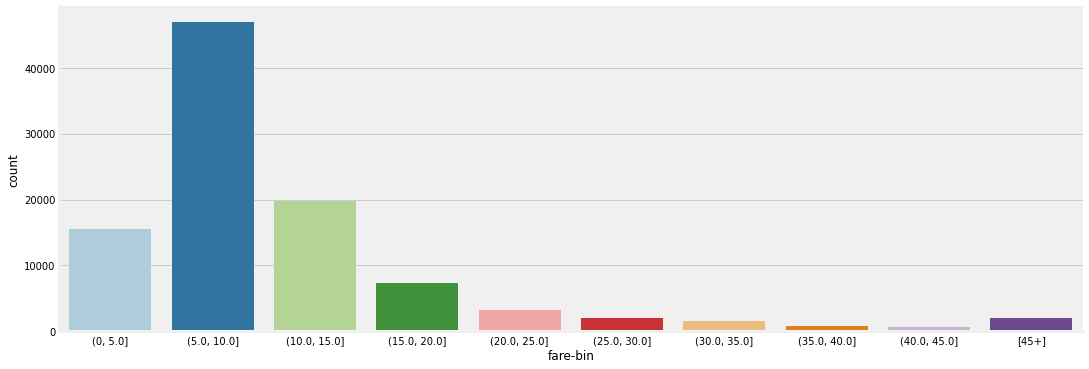

In [10]:
sns.catplot(x="fare-bin", kind="count", palette=palette, data=df, height=5, aspect=3);
plt.show()

### Explore other variables

- passenger_count (statistics + distribution)
- pickup_datetime (you need to build time features out of pickup datetime)
- Geospatial features (pickup_longitude, pickup_latitude,dropoff_longitude,dropoff_latitude)
- Find other variables you can compute from existing data that might explain the target 

#### Passenger Count

In [11]:
df.passenger_count.describe()

count    99991.000000
mean         1.673761
std          1.300083
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

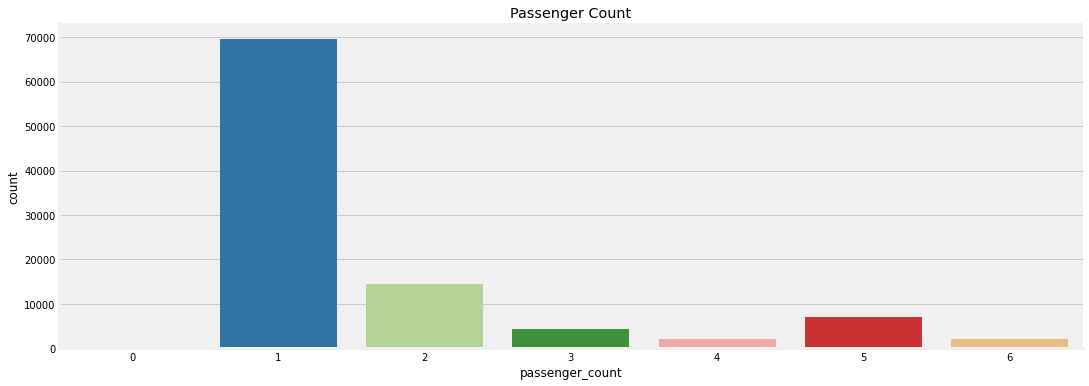

In [12]:
sns.catplot(x="passenger_count", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Passenger Count');
plt.show()

#### Pickup Datetime 
- Extract time features from pickup_datetime (hour, day of week, month, year)
- Create a method `def extract_time_features(_df)` that you will be able to re-use later
- Be careful of timezone
- Explore the newly created features 

In [13]:
def extract_time_features(df):
    """
    Inputs: Original DataFrame
    --------------------------
    Ouptputs: Modified df
    - Index changed to the ppickup date set on a timezone.
    - Additional dayofweek, hour, month and year columns.
    """
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    
    # Allows to change a column to another timezone. NB: The US do not change time during Q4-Q1
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [14]:
%%time
df = extract_time_features(df)

CPU times: user 10.4 s, sys: 33.5 ms, total: 10.5 s
Wall time: 10.5 s


In [15]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year
0,2010-03-18 19:13:39.0000002,0.00,2010-03-18 19:13:39 UTC,-73.942346,40.806269,-73.942463,40.806129,1,"(0, 5.0]",3,15,3,2010
1,2010-02-15 14:26:01.0000003,0.00,2010-02-15 14:26:01 UTC,-73.987115,40.738808,-74.005911,40.713960,1,"(0, 5.0]",0,9,2,2010
2,2015-05-15 21:40:28.00000010,0.00,2015-05-15 21:40:28 UTC,-74.077927,40.805714,-74.077919,40.805721,1,"(0, 5.0]",4,17,5,2015
3,2015-05-01 15:38:41.0000007,0.01,2015-05-01 15:38:41 UTC,-73.939041,40.713963,-73.941673,40.713997,1,"(0, 5.0]",4,11,5,2015
4,2015-02-19 06:18:50.0000001,0.01,2015-02-19 06:18:50 UTC,-73.980331,40.770535,-73.981911,40.771503,1,"(0, 5.0]",3,1,2,2015


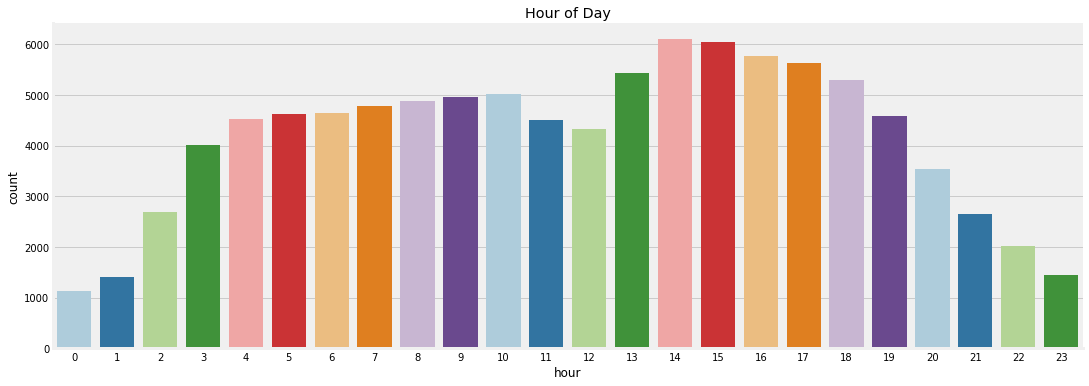

In [16]:
# Check how many taxirides are ongoing at a certain timeslot during the day.
sns.catplot(x="hour", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

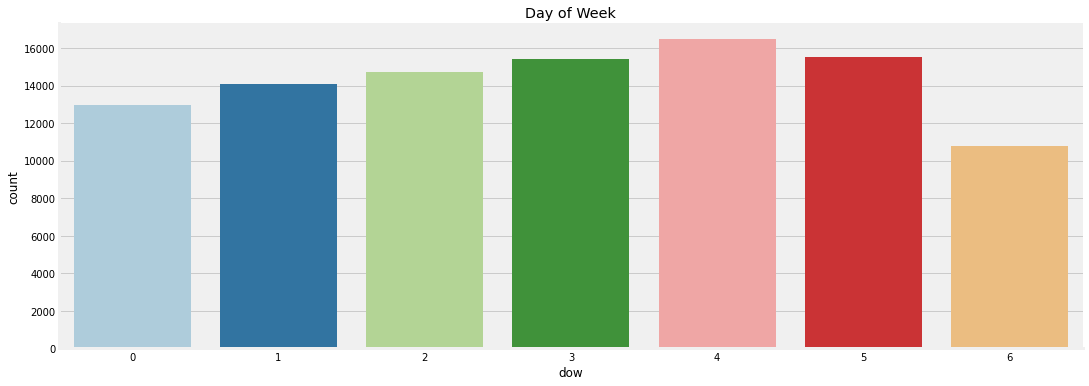

In [17]:
# day of week
sns.catplot(x="dow", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

#### Geospatial Data
- Extract time features from pickup_datetime (hour, day of week, month, year)
- Create a method `def extract_time_features(_df)` that you will be able to re-use later
- Be careful of timezone
- Explore the newly created features 

In [18]:
df_test = pd.read_csv("./data/test.csv")

In [19]:
# Find boudaries from test and remove them from training set
# No data leakage! It is just a way to reduce the training sample and training time to rides as the data set is huge.
for col in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]:
    MIN = df_test[col].min()
    MAX = df_test[col].max()
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [20]:
# Filtering our dataset with the test boundaries found.

# .between is similar to a boolean indexing with an upper and lower border condition.
# Could have been (df["pickup_latitude"] > 40 )
df = df[df["pickup_latitude"].between(left = 40, right = 42 )]
df = df[df["pickup_longitude"].between(left = -74.3, right = -72.9 )]
df = df[df["dropoff_latitude"].between(left = 40, right = 42 )]
df = df[df["dropoff_longitude"].between(left = -74, right = -72.9 )]

In [21]:
# make sur your install folium first
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [22]:
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=12)

In [23]:
%matplotlib notebook
df["count"] =1
heatmap_data = df.head(10000)[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [24]:
heatmap_data_by_hour = []
__df__ = df.head(10000)
for hour in df.hour.sort_values().unique():
    _df = __df__[__df__.hour == hour][['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_df)

In [25]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(m2)
m2

#### Distance
- Compute the `haversine` distance between pickup and dropoff location.
- Write a method `def haversine_distance(df, **kwargs)` that you will be able to reuse later
- Compute a few statistics for distance and plot distance distribution

<h5>Haversine Formula Explained</h5>

<h6>Information:</h6>

* The haversine formula determines the **great-circle distance** between two points on a sphere given their longitudes and latitudes.

* Typical case of use: **Sailing**, **Flying** and all other means of transportation which do not require the use of infrastructures.

<h6>Formula:</h6>
\begin{equation}
d = 2r\arcsin \left ( \sqrt{sin^2 \left ( \frac{\varphi _2 - \varphi _1}{2}  \right ) + cos(\varphi _1)cos(\varphi _2)sin^2 \left (\frac{\lambda _2 - \lambda _1}{2}{} \right )} \right )
\end{equation}

Where:
<ul>
    <li>$r$ is the radius of the earth (6371 km / 3969 mi)</li>
    <li>$\varphi _1$, $\varphi _2$ are the latitudes of point 1 and 2.</li>
    <li>$\lambda _1$, $\lambda _2$ are the longitudes of point 1 and 2.</li>
</ul>

<details>
<summary>Want more info? 👇🏼</summary>
<ul>
    <li>https://en.wikipedia.org/wiki/Haversine_formula</li>
    <li>⚠️The inputs of sklearn's cos and sin should be in radians and not degrees!⚠️</li>
</ul>
</details>


In [26]:
import numpy as np
def haversine_distance(df,
                         start_lat="start_lat",
                         start_lon="start_lon",
                         end_lat="end_lat",
                         end_lon="end_lon"):
    """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees).
        Vectorized version of the haversine distance for pandas df
        Computes distance in kms
    """
    
    # Convert Latitudes and Longitudes to radians (*pi()/180)
    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    
    # Compute the variation in longitude and latiture
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad
    
    # Compute the angle between the two points
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the earth * angle of moving both according to the long and the lat
    haversine_distance = 6371 * c
    return haversine_distance

df["distance"] = haversine_distance(df, 
                                   start_lat="pickup_latitude", start_lon="pickup_longitude",
                                   end_lat="dropoff_latitude", end_lon="pickup_longitude"
                                  )

In [27]:
df.distance.describe()

count    85056.000000
mean         2.341692
std          2.722911
min          0.000000
25%          0.759771
50%          1.537437
75%          2.926094
max         96.625945
Name: distance, dtype: float64

/Users/edgarminault/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


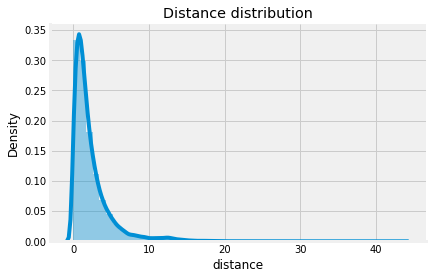

In [28]:
%matplotlib inline
g = sns.distplot(df[df.distance < 50].distance)
sns.despine()
plt.title("Distance distribution")
plt.show()

#### Explore how target variable correlate with other variables
- As a first step, you can vizualize the target variable vs another variable. For categorical variables, it is often useful to compute the average target variable for each category (Seaborn as plots that do it for you!). For continuous variables (like distance, you can use scatter plots, or regression plots, or bucket the distance into different bins.
- But there many different ways to visualize correlation between features, so be creative.

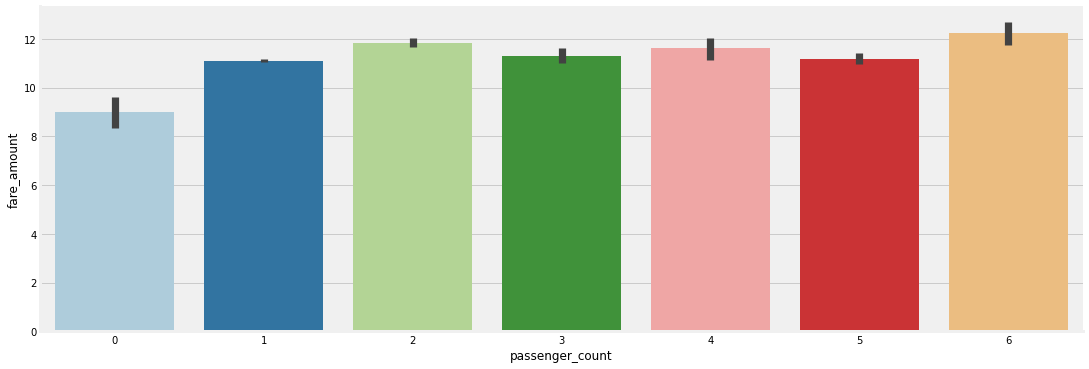

In [29]:
%matplotlib inline
sns.catplot(x="passenger_count", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

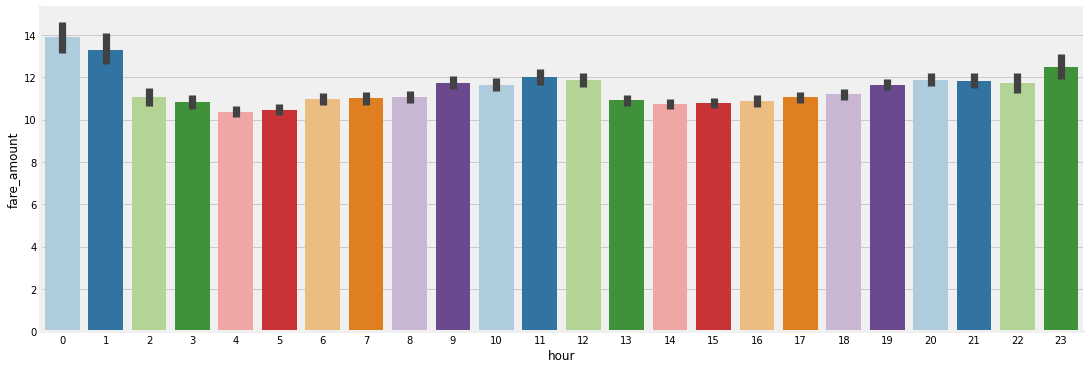

In [30]:
sns.catplot(x="hour", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

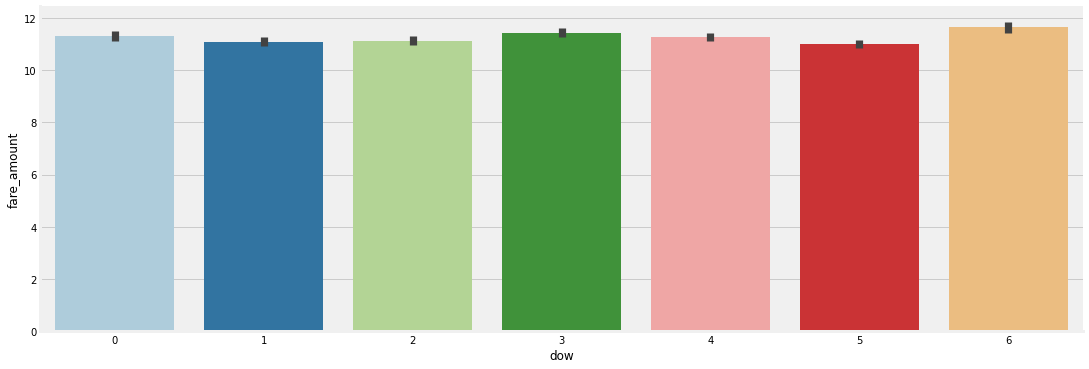

In [31]:
sns.catplot(x="dow", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

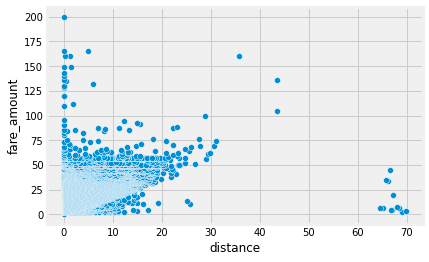

In [32]:
sns.scatterplot(x="distance", y="fare_amount", data=df[df.distance < 70])
plt.show()

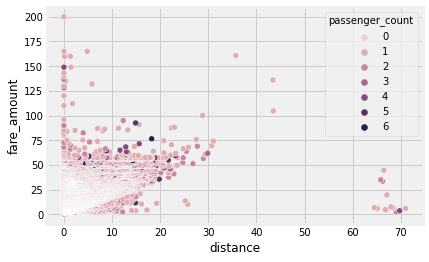

In [33]:
sns.scatterplot(x="distance", y="fare_amount", hue="passenger_count", data=df[df.distance < 80])
plt.show()

## 3. Data cleaning <a id='part3'></a>

As you probably identified in the previous section during your data exploration, there are some values that do not seem valid.
In this section, you will take a few steps to clean the training data.


Remove all trips that look incorrect. We recommand you writing a method `clean_data(df)` that you will be able to re-use in the next steps.

In [34]:
print("trips with negative fares:", len(df[df.fare_amount <= 0]))
print("trips with too high distance:", len(df[df.distance >= 100]))
print("trips with too many passengers:", len(df[df.passenger_count > 8]))
print("trips with zero passenger:", len(df[df.passenger_count == 0]))

trips with negative fares: 1
trips with too high distance: 0
trips with too many passengers: 0
trips with zero passenger: 304


In [35]:
def clean_data(df, test=False):
    df = df.dropna(how='any', axis='rows')
    df = df[df.fare_amount.between(0, 500)]
    df = df[df.passenger_count < 8]
    df = df[df.passenger_count >= 0]
    df = df[df["pickup_latitude"].between(40, 42)]
    df = df[df["pickup_longitude"].between(-74.3, -72.9 )]
    df = df[df["dropoff_latitude"].between(40, 42)]
    df = df[df["dropoff_longitude"].between(-74, -72.9)]
    return df

df_cleaned = clean_data(df)
"% data removed", (1 - len(df_cleaned) / len(df)) * 100

('% data removed', 0.0)

## 4. Evaluation metric <a id='part4'></a>

The evaluation metric for this competition is the root mean-squared error or RMSE. RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better.

More details here https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

Write a method `def compute_rmse(y_pred, y_true)` that computes the RMSE given `y_pred` and `y_true` which are two numpy arrays corresponding to model predictions and ground truth values.

This method will be useful to evaluate performance of your model

In [36]:
def compute_rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true)**2).mean())

## 5. Model baseline <a id='part5'></a>

Before building your model, it is often useful to get a performance benchmark. For this, you will use a baseline model that is a very dumb model and compute the evualation metric on that model.
Then, you will be able to see how much better your model is compared to the baseline. It is very common to see ML teams comming up with very sophisticated approaches without knowing by how much their model beats the very simple model.

- Generate predictions based on a simple heuristic
- Evaluate RMSE for these predictions

In [37]:
y_pred = df_cleaned.fare_amount.mean()
df["y_pred"] = df_cleaned.fare_amount.mean()
compute_rmse(df.y_pred, df.fare_amount)

9.455298157195438

## 6. Build your first model <a id='part6'></a>

Now it is time to build your model!

To start we are going to use a linear model only. We will try more sophisticated models later during day 2.

Here are the different steps you have to follow:

1. Split the data into two different sets (training and validation). You will be measuring the performance of your model on the validation set.
2. Make sure you apply the data cleaning on your training set
3. Think about the different features you want to add in your model
4. For each of these features, make sure you apply the correct transformation so that the model can correctly learn from them (this is true for categorical variables like `hour of day` or `day of week`)
5. Train your model

##### Training/Validation Split

In [38]:
# training/validation
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.1)

##### Apply data cleaning on training set

In [39]:
df_train = clean_data(df_train)

In [40]:
df_train

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance,y_pred
3975,2012-11-07 15:57:37.0000001,4.00,2012-11-07 15:57:37 UTC,-73.994771,40.740401,-73.994728,40.740423,1,"(0, 5.0]",2,10,11,2012,1,0.002446,11.252726
7093,2010-10-03 21:19:19.0000005,4.50,2010-10-03 21:19:19 UTC,-73.982096,40.769191,-73.987522,40.773706,1,"(0, 5.0]",6,17,10,2010,1,0.502045,11.252726
98387,2011-02-10 09:58:44.0000001,49.80,2011-02-10 09:58:44 UTC,-73.991287,40.744227,-73.776227,40.645750,1,[45+],3,4,2,2011,1,10.950143,11.252726
53263,2012-01-26 08:35:00.000000160,8.90,2012-01-26 08:35:00 UTC,-73.965045,40.769667,-73.950402,40.771522,1,"(5.0, 10.0]",3,3,1,2012,1,0.206267,11.252726
54089,2012-08-09 10:34:16.0000003,8.90,2012-08-09 10:34:16 UTC,-73.939446,40.805217,-73.952743,40.779302,2,"(5.0, 10.0]",3,6,8,2012,1,2.881617,11.252726
67718,2012-12-15 04:08:00.00000030,11.00,2012-12-15 04:08:00 UTC,-73.958252,40.712627,-73.933667,40.698092,1,"(10.0, 15.0]",4,23,12,2012,1,1.616218,11.252726
52119,2014-02-10 08:42:00.00000062,8.50,2014-02-10 08:42:00 UTC,-73.986970,40.755657,-73.975442,40.755597,5,"(5.0, 10.0]",0,3,2,2014,1,0.006672,11.252726
27329,2011-11-22 08:37:46.0000002,6.10,2011-11-22 08:37:46 UTC,-73.986253,40.745846,-73.973876,40.751409,1,"(5.0, 10.0]",1,3,11,2011,1,0.618577,11.252726
40986,2015-02-07 13:27:38.0000004,7.50,2015-02-07 13:27:38 UTC,-74.006035,40.717499,-73.998894,40.734631,1,"(5.0, 10.0]",5,8,2,2015,1,1.904970,11.252726
80874,2012-11-20 16:32:54.0000001,14.50,2012-11-20 16:32:54 UTC,-73.984873,40.728245,-73.991793,40.749023,1,"(10.0, 15.0]",1,11,11,2012,1,2.310408,11.252726


##### List features (continuous vs categorical)

In [41]:
# features
target = "fare_amount"
features = ["distance"]
categorical_features = ["hour", "dow", "passenger_count"]

##### Features transformation
- Write a method `def transform_features(df, **kwargs)` because you will have to make sure you apply the same transformation on the validation (or test set) before making predictions
- For categorical features transformation, you can use `pandas.get_dummies` method

In [42]:
def transform_features(_df, dummy_features=None):
    # If no dummy features is given, the aim is to encode features
    encode = True if dummy_features is None else False
    
    # Initiate dummy_features as input or empty list
    dummy_features = dummy_features if dummy_features is not None else []
    
    # Check the features in the categorical features cited in the cell above.
    for c in categorical_features:
        
        # Each column of the dummified df is called df[columnname_value]
        dummies = pd.get_dummies(_df[c], prefix=c)
        
        # Add the dummied columns to the dataframe
        _df = pd.concat([_df, dummies], axis=1)
        
        # If no dummy features has been given, then we should encode the categorical features
        if encode:
            dummy_features = dummy_features + (list(dummies.columns.values))
    
    for dummy_feature in [f for f in dummy_features if f not in _df.columns]:
        _df[dummy_feature] = 0 
    _df = _df[dummy_features + features]
    return _df, dummy_features

##### Model training

In [43]:
# model training
from sklearn.linear_model import LassoCV
clf = LassoCV(cv=5, n_alphas=5)
X_train, dummy_features = transform_features(df_train)
y_train = df_train.fare_amount
clf.fit(X_train, y_train)

LassoCV(cv=5, n_alphas=5)

## 7. Model evaluation <a id='part7'></a>

Now to evaluate your model, you need to use your previously trained model to make predictions on the validation set. 

For this, follow these steps:
1. Apply the same transformations on the validation set
2. Make predictions
3. Evaluate predictions using `compute_rmse` method

In [44]:
X_val, _ = transform_features(df_val, dummy_features=dummy_features)
df_val["y_pred"] = clf.predict(X_val)
compute_rmse(df_val.y_pred, df_val.fare_amount)

/Users/edgarminault/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


7.357466243168092

## 8. Kaggle submission <a id='part8'></a>

Now that you have a model, you can now make predictions on Kaggle test set and be evaluated by Kaggle directly.

- Download test data from Kaggle
- Follow [instructions](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation) to make sure your predictions are in the right format
- Re-train your model using all the data (do not split between train/validation)
- Apply all features engineering and transformations methods on the test set
- Use the model to make predictions on the test set
- Submit your predictions!

In [109]:
df_test = pd.read_csv("./data/test.csv")

df_test["distance"] = haversine_distance(df_test, 
                                   start_lat="pickup_latitude", start_lon="pickup_longitude",
                                   end_lat="dropoff_latitude", end_lon="pickup_longitude"
                                  )
df_test = extract_time_features(df_test)
X_test, _ = transform_features(df_test, dummy_features=dummy_features) 
df_test["y_pred"] = clf.predict(X_test)

df_test.reset_index(drop=True)[["key", "y_pred"]].rename(columns={"y_pred": "fare_amount"}).to_csv("lasso_v0_predictions.csv", index=False)

## 9. Push further Feature Engineering <a id='part9'></a>

You can improve your model by trying different things (But dont' worry, some of these things will be covered in the next days).
- Use more data to train
- Build and add more features 
- Try different estimators
- Adjust your data cleaning to remove more or less data
- Tune the hyperparameters of your model

On following section we will focus on advanced Feature Engineering (keep in mind that relevant feateng is often key to significant increase in model performances):

👉 **Manhattan distance** better suited to our problem  
👉 **Distance to NYC center** to highlight interesting pattern ...  
👉 **Direction**   

###### Another Distance ?
- Think about the distance you used, try and find a more adapted distance to our problem (Ask TA for insights)

![Minkowski distance](https://wikimedia.org/api/rest_v1/media/math/render/svg/4ed8b780e0d3224880760b1745c444481590ee86)

In [101]:
# Minkowski Distance is actually the generic distance to compute differnet distance
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

In [102]:
df['manhattan_dist'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 1)

df['euclidian_dist'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 2)

In [103]:
columns_mink = ['euclidian_dist', 'manhattan_dist']

In [111]:
%%time
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(df[columns_mink]), columns = columns_mink)

CPU times: user 6.82 ms, sys: 1.64 ms, total: 8.46 ms
Wall time: 6.93 ms


,euclidian_dist,manhattan_dist
0,0.000135,0.000131
1,0.003012,0.002587
2,0.001815,0.001695
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000695,0.000705
6,0.001665,0.001474
7,0.000045,0.000047
8,0.003753,0.003470
9,0.002315,0.002106


In [106]:
def minkowski_distance_bis(lat1, lat2, lon1, lon2, p):
    delta_lat = (lat2 - lat1) * np.pi / 180
    delta_lon = (lon2 - lon1) * np.pi / 180
    delta_x = delta_lon * np.cos((lat1+lat2)/2)
    delta_y = delta_lat
    return 6371 * ((abs(delta_x) ** p) + (abs(delta_y)) ** p) ** (1 / p)

In [107]:
# euclidian distance = minkowski_distance(x1, x2, y1, y2, p) where p=2
# manhattan distance = minkowski_distance(x1, x2, y1, y2, p) where p=1
df['manhattan_dist'] = minkowski_distance_bis(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 1)

df['euclidian_dist'] = minkowski_distance_bis(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 2)

In [110]:
%%time
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(df[columns_mink]), columns = columns_mink)

CPU times: user 6.63 ms, sys: 1.96 ms, total: 8.59 ms
Wall time: 7.1 ms


,euclidian_dist,manhattan_dist
0,0.000135,0.000131
1,0.003012,0.002587
2,0.001815,0.001695
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000695,0.000705
6,0.001665,0.001474
7,0.000045,0.000047
8,0.003753,0.003470
9,0.002315,0.002106


In [72]:
%%time
np.cos(0.4)

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 23.1 µs


0.9210609940028851

###### Distance from the center 
- Compute a new Feature calculating distance of pickup location from the center
- Scatter Plot *distance_from_center* regarding *distance* 
- What do you observe ? What new features could you add ? How are these new features correlated to the target ?

In [ ]:
# Let's compute distance from NYC center
nyc_center = (40.7141667, -74.0063889)
df["nyc_lat"], df["nyc_lng"] = nyc_center[0], nyc_center[1]
args =  dict(start_lat="nyc_lat", start_lon="nyc_lng",
            end_lat="pickup_latitude", end_lon="pickup_longitude")

df['distance_to_center'] = haversine_distance(df, **args)

In [ ]:
idx = (df.distance < 40) & (df.distance_to_center < 40)
sns.scatterplot(x="distance_to_center", y="distance", data=df[idx].sample(10000), hue="fare-bin")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

> The further from the center, the more expensive the fare.

In [ ]:
df.distance_to_center.hist(bins=100)

👉 **Take time to step back conlude interesting pattern here ? What are these clustered with same distance to center?**

In [ ]:
# Seems to be fixed distance_to_center
jfk_center = (40.6441666667, -73.7822222222)


df["jfk_lat"], df["jfk_lng"] = jfk_center[0], jfk_center[1]
args_pickup =  dict(start_lat="jfk_lat", start_lon="jfk_lng",
            end_lat="pickup_latitude", end_lon="pickup_longitude")
args_dropoff =  dict(start_lat="jfk_lat", start_lon="jfk_lng",
            end_lat="dropoff_latitude", end_lon="dropoff_longitude")

jfk = (-73.7822222222, 40.6441666667)
df['pickup_distance_to_jfk'] = haversine_distance(df, **args_pickup)
df['dropoff_distance_to_jfk'] = haversine_distance(df, **args_dropoff)

In [ ]:
df.pickup_distance_to_jfk.hist(bins=100)

###### Which direction  you heading to ?
- Compute a new Feature calculating the direction your heading to
- What do you observe ? What new features could you add ? How are these new features correlated to the target ?

In [ ]:
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

In [ ]:
df['delta_lon'] = df.pickup_longitude - df.dropoff_longitude
df['delta_lat'] = df.pickup_latitude - df.dropoff_latitude
df['direction'] = calculate_direction(df.delta_lon, df.delta_lat)

In [ ]:
plt.figure(figsize=(10,6))
df.direction.hist(bins=180)

In [ ]:
# plot direction vs average fare amount for fares inside manhattan
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(df, BB_manhattan)


fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df[idx_manhattan]['direction'], np.linspace(-180, 180, 37))
df[idx_manhattan].pivot_table('fare_amount', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)
plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

In [ ]:
corrs = df.corr()
l = list(corrs)
l.remove("fare_amount")
corrs['fare_amount'][l].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');